reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.

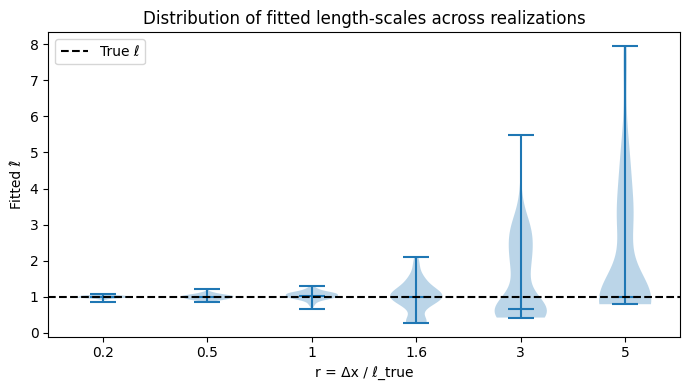

In [1]:
from math import sqrt, pi
from mpmath import erfc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
 
import GPy
# -----------------------------
# Parameters
# -----------------------------
left, right = -5, 15
L = right - left
n_fine = 500
var_true = 2.0
ell_true = 1.0
noise = 1e-6

# Fine grid
X = np.linspace(left, right, n_fine)[:, None]

# -----------------------------
# Generate one "true" GP realization
# -----------------------------
k_true = GPy.kern.RBF(input_dim=1, variance=var_true, lengthscale=ell_true)
K_true = k_true.K(X, X) + noise*np.eye(n_fine)
Y = np.random.multivariate_normal(mean=np.zeros(n_fine), cov=K_true)[:, None]

# -----------------------------
# Subsample ratios
# -----------------------------
r_values = [0.2,0.5, 1.0, 1.6, 3.0, 5.0]
 # -----------------------------
# Function: simulate one realization, fit at different r
# -----------------------------
def run_one(seed=None):
    rng = np.random.default_rng(seed)
    k_true = GPy.kern.RBF(input_dim=1, variance=var_true, lengthscale=ell_true)
    K_true = k_true.K(X, X) + noise * np.eye(n_fine)
    Y = rng.multivariate_normal(mean=np.zeros(n_fine), cov=K_true)[:, None]

    results = []
    for r in r_values:
        dx = r * ell_true
        N = int(np.floor(L / dx)) + 1
        X_sub = np.linspace(left, right, N)[:, None]

        idx = np.clip((X_sub - left) / L * (n_fine - 1), 0, n_fine - 1).astype(int).flatten()
        Y_sub = Y[idx]

        # Fit GP
        k_fit = GPy.kern.RBF(input_dim=1)
        m = GPy.models.GPRegression(X_sub, Y_sub, k_fit)
        m.Gaussian_noise.variance.constrain_bounded(1e-6, 1e-3)  # tiny but >0
        m.rbf.lengthscale.constrain_bounded(0.05, 10.0)
        m.optimize(messages=False, max_iters=1000)

        mu, var = m.predict(X)
        rmse = np.sqrt(np.mean((mu.flatten() - Y.flatten())**2))

        z = pi / (sqrt(2) * r)
        epsilon = float(erfc(z))
        rmse_theory = np.sqrt(epsilon * var_true)

        results.append(dict(r=r, N=N,
                            ell_fit=float(m.rbf.lengthscale.values),
                            rmse=rmse,
                            rmse_theory=rmse_theory,
                            epsilon=epsilon))
    return results

# -----------------------------
# Run multiple realizations
# -----------------------------
M = 100
all_results = []
for seed in range(M):
    all_results.extend(run_one(seed))

df = pd.DataFrame(all_results)

# -----------------------------
# Plot 1: violin of fitted ℓ vs r
# -----------------------------
fig, ax = plt.subplots(figsize=(7,4))
data = [df.loc[df.r==r, 'ell_fit'].values for r in r_values]
ax.violinplot(data, positions=range(len(r_values)), showmedians=True)
ax.axhline(ell_true, linestyle='--', color='k', label="True ℓ")
ax.set_xticks(range(len(r_values)))
ax.set_xticklabels([f"{r:g}" for r in r_values])
ax.set_xlabel("r = Δx / ℓ_true")
ax.set_ylabel("Fitted ℓ̂")
ax.set_title("Distribution of fitted length-scales across realizations")
ax.legend()
plt.tight_layout()
plt.savefig("violin_lengthscale.png", dpi=200)
